In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import Simulator_Functions as SF
from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList

## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Default GPU Device: /device:GPU:0


Using TensorFlow backend.


In [2]:
## Network Model Parameters
Random_Seed = 42
model_name  = 'Single_Cross_Straight'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
program = 'DuelingDDQN' # DQN, DuelingDQN, DDQN, DuelingDDQN
reward_type = 'Queues'
state_type  = 'Queues'
PER_activated = True
## Use of additional files?
flag_read_additionally  = False
## Load trained model?
Demo_Mode = False
load_trained = False
Quickmode = True
SaveResultsAgent = True
# Random demand
Random_Demand = False

In [3]:
## Data handling flags
# Flag for restarting the COM Server
reset_flag = True
#cache_flag = False
# If a fresh start is needed, all previous results from simulations are deleted
Start_Fresh = True
# Debug action
debug_action = False

In [4]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 30
partial_save_at = 10
copy_weights_frequency = 5
reset_frequency = 10

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
simulation_length = 36000*1 + 1
memory_population_length = simulation_length*5

## State-Action Parameters
state_size = 4
action_size = 5

# Hyperparameters
batch_size = 32
memory_size = 100
#alpha   = 0.0001
alpha   = 0.001

gamma   = 0.95

# Exploration Schedule
epsilon_start = 1
epsilon_end   = 0.001
epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
#epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes+1)) # Geometric decay

# Demand Schedule
demands = [100, 200, 400, 600, 800, 1000]
# Session ID
Session_ID = 'Episodes'+str(episodes)+'_Program'+program

In [5]:
if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    loss=[]
    
    # If previous agents aren't to be loaded, proceed to memory population
    if not load_trained:
        # Initialize simulation
        if 'Vissim' not in globals() or Vissim == None:
            Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                        memory_population_length, Start_Fresh,\
                                                                        reset_flag = True, verbose = True)
        else:
            Vissim = com.Dispatch("Vissim.Vissim")
            Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                  memory_population_length, Start_Fresh, reset_flag = True)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if program == "DQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = False,\
                           Dueling = False) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DuelingDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = False,\
                           Dueling = True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = True,\
                           Dueling = False) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DuelingDDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = True,\
                           Dueling = True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), program))
    
    if Demo_Mode:
        Agents, loss = SF.load_agents(vissim_working_directory, model_name, Agents, Session_ID, loss, best = True)
        SF.run_simulation_episode(Agents, Vissim, state_type, state_size, memory_population_length, Demo_Mode, PER_activated)
        Vissim = None
    # Load previous trained data
    elif load_trained:
        Agents, loss = SF.load_agents(vissim_working_directory, model_name, Agents, Session_ID, loss, best = False)
    # If previous data isn't to be loaded, have an initial longer random run to populate memory
    else:
        print('Pre-Populating memory with Random Actions....')
        SF.Set_Quickmode(Vissim)
        if PER_activated:
            memory = SF.PER_prepopulate_memory(Agents, Vissim, state_type, state_size, memory_size, vissim_working_directory, model_name)
        else:
            SF.run_simulation_episode(Agents, Vissim, state_type, state_size, 100000000, Demo_Mode, PER_activated)
        print('Memory pre-populated. Starting Training.\n')
    # Iterations of the simulation
    for episode in range(episodes):
        # Completely re-dispatch server every N iterations for performance
        if episode % reset_frequency == 0 and episode !=0:
            Vissim = None
            Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                        simulation_length, Start_Fresh,\
                                                                        reset_flag = True, verbose = False)
            print("Redispatched")
        else:
            # If not the first episode, reset state at the start
            Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                simulation_length, Start_Fresh, reset_flag = True)
        npa = NetworkParser(Vissim) 
        for index, agent in enumerate(Agents):
            agent.update_IDS(npa.signal_controllers_ids[index], npa)
            agent.episode_reward = []
        
        # Change demand for every episode
        if Random_Demand:
            for vehicle_input in range(1,5):
                Vissim.Net.VehicleInputs.ItemByKey(vehicle_input).SetAttValue('Volume(1)', demands[np.random.randint(0,len(demands)-1)])    
        
        # Run Episode at maximum speed

        SF.Set_Quickmode(Vissim)
        SF.run_simulation_episode(Agents, Vissim, state_type, state_size, simulation_length, Demo_Mode, PER_activated)
        
        # Calculate episode average reward
        reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
        best_agent_weights = SF.best_agent(reward_storage, average_reward, best_agent_weights, vissim_working_directory, model_name, Agents, Session_ID)
        
        # Train agent with experience of episode (indicated batch size)
        for agent in Agents:
            loss = agent.replay_batch(batch_size, episode, loss)
            #break
        # Security save for long trainings
        if SaveResultsAgent:
            if (episode+1)%partial_save_at == 0:
                SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage, loss)
                print('Saved Partial results at the end of episode {}.'.format(episode+1))

    #Saving agents memory, weights and optimizer
    if SaveResultsAgent:
        SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage, loss)
        print("Model, architecture, weights, optimizer, memory and training results succesfully saved. Succesfully Terminated.")
    
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Loading Model File: Single_Cross_Straight.inpx ...
Load process successful
Simulation length set to 18000.5 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Instructions for updating:
Colocations handled automatically by placer.
Deploying in

Episode: 28/30, Epsilon:-0.03, Average reward: -93.52
Prediction for [500,0,500,0] is: [[-604.6364  -553.5848  -543.24286 -623.99963 -674.2857 ]]
Episode: 29/30, Epsilon:-0.03, Average reward: -93.52
Prediction for [500,0,500,0] is: [[-615.89166 -565.7021  -554.10846 -632.03754 -689.06335]]
Episode: 30/30, Epsilon:-0.03, Average reward: -93.52
Prediction for [500,0,500,0] is: [[-626.27997 -577.00116 -565.81006 -639.27747 -702.9714 ]]
Weights succesfully copied to Target model.
Saving architecture, weights and optimizer state for agent-0
Dumping agent-0 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saved Partial results at the end of episode 30.
Saving architecture, weights and optimizer state for agent-0
Dumping agent-0 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Model, architecture, weights, optimizer, memory and training results succesfully saved. Succesfully Term

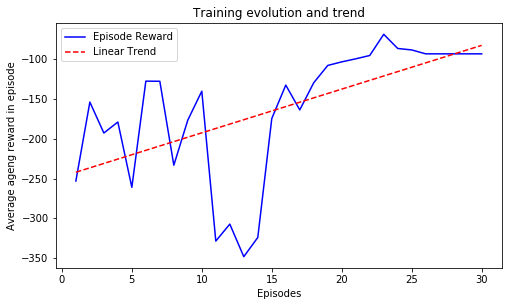

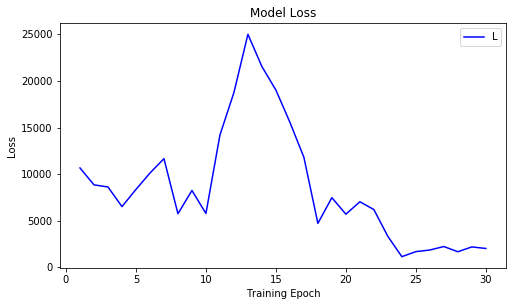

In [6]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average ageng reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(loss)+1)
plt.plot(x_series,loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [7]:
p_min = 0.01
n=4
PER_b = 0.401

max_weight = (p_min * n) ** (-PER_b)
max_weight

3.635581991135161

In [8]:
np.min(Agents[0].memory.tree.tree[-Agents[0].memory.tree.capacity:])
#Agents[0].memory.tree.total_priority

1.0

In [9]:
type(memory)

list

In [10]:
PER_prepopulation_filename =  os.path.join(vissim_working_directory, model_name, 'PER_Prepopulation_length_'+ str(memory_size) +'.p')
memory2 = pickle.load(open(PER_prepopulation_filename, 'rb'))
memory2

[(array([[0, 0, 0, 0]]),
  0,
  -37.68891539902296,
  array([[17.03607107,  0.57415953, 18.08797682,  1.99070798]])),
 (array([[17.03607107,  0.57415953, 18.08797682,  1.99070798]]),
  3,
  -140.54659879156864,
  array([[89.80993566,  1.23437294, 48.42109635,  1.08119384]])),
 (array([[89.80993566,  1.23437294, 48.42109635,  1.08119384]]),
  4,
  -284.7241945653423,
  array([[198.80856254,   1.55569206,  84.35993996,   0.        ]])),
 (array([[198.80856254,   1.55569206,  84.35993996,   0.        ]]),
  3,
  -400.44345118573005,
  array([[239.18220046,   0.        , 161.26125073,   0.        ]])),
 (array([[239.18220046,   0.        , 161.26125073,   0.        ]]),
  4,
  -463.13075336895713,
  array([[230.10599279,   2.66720566, 229.76453596,   0.59301897]])),
 (array([[230.10599279,   2.66720566, 229.76453596,   0.59301897]]),
  3,
  -493.1271943655583,
  array([[246.23946274,   0.        , 246.35305957,   0.53467206]])),
 (array([[246.23946274,   0.        , 246.35305957,   0.53467

In [11]:
memory

[(array([[0, 0, 0, 0]]),
  0,
  -37.68891539902296,
  array([[17.03607107,  0.57415953, 18.08797682,  1.99070798]])),
 (array([[17.03607107,  0.57415953, 18.08797682,  1.99070798]]),
  3,
  -140.54659879156864,
  array([[89.80993566,  1.23437294, 48.42109635,  1.08119384]])),
 (array([[89.80993566,  1.23437294, 48.42109635,  1.08119384]]),
  4,
  -284.7241945653423,
  array([[198.80856254,   1.55569206,  84.35993996,   0.        ]])),
 (array([[198.80856254,   1.55569206,  84.35993996,   0.        ]]),
  3,
  -400.44345118573005,
  array([[239.18220046,   0.        , 161.26125073,   0.        ]])),
 (array([[239.18220046,   0.        , 161.26125073,   0.        ]]),
  4,
  -463.13075336895713,
  array([[230.10599279,   2.66720566, 229.76453596,   0.59301897]])),
 (array([[230.10599279,   2.66720566, 229.76453596,   0.59301897]]),
  3,
  -493.1271943655583,
  array([[246.23946274,   0.        , 246.35305957,   0.53467206]])),
 (array([[246.23946274,   0.        , 246.35305957,   0.53467

In [12]:
memory2[0]

(array([[0, 0, 0, 0]]),
 0,
 -37.68891539902296,
 array([[17.03607107,  0.57415953, 18.08797682,  1.99070798]]))

In [13]:
a =Agents[0].memory

In [14]:
for s,a,r,ns in memory2:

    Agents[0].remember(s,a,r,ns)

In [15]:
ag[0].memory.tree.total_priority

NameError: name 'ag' is not defined

In [ ]:
for s,a,r,ns in memory2:

    ag[0].remember(s,a,r,ns)

In [ ]:
ag[0].memory.tree.total_priority

In [ ]:
ag[0].memory.sample(4)

In [ ]:
(2*4)**(-.404)